In [1]:
import numpy as np
import os
import torch
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union
from transformers import PreTrainedModel, AutoModelForSequenceClassification, T5ForConditionalGeneration
from transformers import AutoTokenizer
import datasets

import math
from matplotlib import pyplot as plt


from typing import List, Optional, Tuple, Union
from transformers import BertForSequenceClassification
import transformers
from transformers.modeling_outputs import SequenceClassifierOutput

### Finetune

In [1]:
pwd

'/cephfs/home/bulatov/bulatov/RMT_light/framework/notebooks'

In [2]:
import sys
sys.path.append('..')
from transformers import AutoModelForSequenceClassification
from modeling_rmt import RMTEncoderForSequenceClassification
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
# from modeling_rmt import RMTEncoderForSequenceClassification
# from modeling_rmt_enc_dec import RMTEncoderDecoderForConditionalGeneration

In [3]:
num_segments = 4
num_mem_tokens = 10
# device = torch.device(3)
device = 'cpu'

In [4]:
model_name = 'bert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(model_name)

rmt_config = {'num_mem_tokens': num_mem_tokens, 
                'max_n_segments': num_segments,
                'tokenizer': tokenizer,
               #  'memory_layers': 'all', 
               #  'share_memory_layers': True,
               #  'reconstruction_loss_coef': 0.1,
                'segment_ordering': 'regular',
                'input_size': 512, 
                'bptt_depth': -1, 
                'sum_loss': False,
             }

# base_model1 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
# rmt1 = RMTEncoderForSequenceClassification(base_model1, **rmt_config)

# base_model2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
# rmt2 = RMTEncoderForSequenceClassification(base_model2, **rmt_config)

base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6).cpu()
rmt = RMTEncoderForSequenceClassification(base_model, **rmt_config).cpu()

# rmt = RMTEncoderMemoryLayers(base_model, **rmt_config)
# rmt = RMTEncoderMLMMemLoss(base_model, **rmt_config)
# rmt = RMTEncoderHorizontalMemory(base_model, **rmt_config)
# rmt.to(device)

/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the che

In [5]:
# cpt = torch.load('../../runs/curriculum_task/babilong_random_v2/bert-base-cased/lr1e-05_linear_adamw_wd1e-03_998-512-{3}seg_mem10_bs32_iters3000_regular_from_cpt_1-2/run_1/model_best.pth', map_location=device)
cpt = torch.load('../../runs/curriculum_task/babilong_reasoning/bert-base-cased/linear_adamw_wd1e-03_1996-512-{4}seg_mem10_bs32_regular_from_cpt_3-4/run_1/model_best.pth', map_location=device)

In [6]:
rmt.load_state_dict(cpt['model_state_dict'])
# rmt1.load_state_dict(cpt1['model_state_dict'])
# rmt2.load_state_dict(cpt2['model_state_dict'])

<All keys matched successfully>

In [7]:
# out = rmt(sample_input_ids, **kwargs, output_hidden_states=False, output_attentions=False)
# out.keys()

### load dataset 

In [8]:
class Holder:
    def __init__(self):
        pass

In [9]:
input_seq_len = 499 * 4
target_seq_len = 512
batch_size = 1

args = Holder
args.num_mem_tokens = 10
args.max_n_segments = 4
args.input_size = 512
args.target_seq_len = target_seq_len
args.input_seq_len = input_seq_len
args.input_prefix = ''
device = 'cpu'

In [10]:
import pandas as pd
from datasets import load_dataset
class MemoryReasoningDataset(Dataset):
    def __init__(self, split='train', dataset='quality', num_samples=None):
        self.dataset = load_dataset('tau/scrolls', dataset)[split]
        self.fact_dataset = pd.read_csv('/home/bulatov/bulatov/datasets/babi/_processed/two_facts_reasoning.csv')
        self.num_samples = num_samples

    def __getitem__(self, ind):
        
        noise_ind = np.random.randint(len(self.dataset))
        fact_ind = np.random.randint(len(self.fact_dataset))
        sample = self.dataset[noise_ind]
        sample.update(dict(self.fact_dataset.iloc[fact_ind]))
        return sample
    
    def __len__(self):
        return self.num_samples

In [11]:
train_dataset = MemoryReasoningDataset(split='train', dataset='quality', num_samples=100_000)
valid_dataset = MemoryReasoningDataset(split='validation', dataset='quality', num_samples=2_000)

Found cached dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/quality/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
Found cached dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/quality/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

### enc-dec

In [12]:
# # raise NotImplementedError
# global_attention_first_token = False  # should be True for LED
# encode_plus_kwargs = {'truncation': True, 'padding': 'longest', 'pad_to_multiple_of': 1}
# # generate_kwargs = {'max_length': args.target_seq_len, 'min_length': args.target_seq_len}
# generate_kwargs = {}

# def collate_fn(batch):
#     # cut too long strings because they may slow down tokenization
#     inputs = [b['fact'] + b['input'][:args.input_seq_len * 10] for b in batch]
#     questions = [b['question'] for b in batch]
#     labels = [b['answer'][:args.target_seq_len * 10] for b in batch]
#     if args.input_prefix:
#         inputs = [args.input_prefix + inp for inp in inputs]

#     max_length = min(args.max_n_segments * input_seg_size, args.input_seq_len)
#     features = tokenizer.batch_encode_plus(list(inputs), return_tensors='pt', **encode_plus_kwargs, max_length=max_length)
#     questions = tokenizer.batch_encode_plus(list(questions), return_tensors='pt', **encode_plus_kwargs)['input_ids']

#     with tokenizer.as_target_tokenizer():
#         labels = tokenizer.batch_encode_plus(list(labels), max_length=args.target_seq_len, return_tensors='pt',
#                                                 **encode_plus_kwargs).input_ids
#     labels[labels == tokenizer.pad_token_id] = -100
#     features['labels'] = labels
#     features['id'] = [b['id'] for b in batch]
#     features['target_text'] = [b['answer'] for b in batch]
#     if 'global_attention_mask' in features:
#         raise RuntimeError('What global attention mask for Longformer and LongformerEncoder-Decoder should be?')
#     return features


### enc

In [13]:
answers = train_dataset.fact_dataset.answer.unique()
labels_map = dict(zip(answers, range(len(answers))))
num_labels = len(labels_map)
if args.num_mem_tokens is None:
    input_seg_size = args.input_size
else:
    input_seg_size = args.input_size - args.num_mem_tokens - tokenizer.num_special_tokens_to_add()
    if 'sep_token' in tokenizer.special_tokens_map:
        input_seg_size -= 1

In [14]:
fact1_segment = 0
fact2_segment = 2
random_position = False

In [15]:
encode_plus_kwargs = {
                            #   'max_length': args.input_seq_len,
                              'truncation': True,
                              'padding': 'longest',
                              'pad_to_multiple_of': 1}

In [16]:
def collate_fn(batch, input_seg_size=input_seg_size, fact1_segment=fact1_segment, fact2_segment=fact2_segment, random_position=random_position):
    facts1 = [b['fact1'] for b in batch]
    facts2 = [b['fact2'] for b in batch]
    inputs = [' '.join([b['input']]) * int(np.ceil(args.input_seq_len * 10 / len(b['input']))) for b in batch]
    questions = [b['question'] for b in batch]
    labels = [b['answer'][:args.target_seq_len * 10] for b in batch]
    if args.input_prefix:
        inputs = [args.input_prefix + inp for inp in inputs]

    total_input_size = args.max_n_segments * input_seg_size
    features = tokenizer.batch_encode_plus(list(inputs), return_tensors='pt', **encode_plus_kwargs, max_length=total_input_size)
    questions = tokenizer.batch_encode_plus(list(questions), return_tensors='pt', **encode_plus_kwargs)['input_ids']

    if random_position:
        fact1_start_positions = np.random.randint(0, args.max_n_segments, len(batch)) * input_seg_size + 1
        fact2_start_positions = np.random.randint(0, args.max_n_segments, len(batch)) * input_seg_size + 1
    else:
        fact1_start_positions = np.ones(len(batch), dtype=int) * fact1_segment * input_seg_size + 1
        fact2_start_positions = np.ones(len(batch), dtype=int) * fact2_segment * input_seg_size + 1

    for i, (position1, position2) in enumerate(zip(fact1_start_positions, fact2_start_positions)):
        fact1 = tokenizer.encode(facts1[i], return_tensors='pt', add_special_tokens=False)[0]
        fact2 = tokenizer.encode(facts2[i], return_tensors='pt', add_special_tokens=False)[0]
        if position1 == position2:
            position2 += len(fact1)
        features['input_ids'][i, position1:position1 + len(fact1)] = fact1
        features['input_ids'][i, position2:position2 + len(fact2)] = fact2

    q_len = questions.shape[1] - 1
    max_length = min(args.max_n_segments * input_seg_size, args.input_seq_len)
    features['input_ids'] = torch.cat([features['input_ids'][:, :max_length - q_len], questions[:, 1:]], dim=1)
    
    labels = np.array([labels_map[t] for t in labels])
    features['labels'] = torch.from_numpy(labels)
    return features

In [17]:
# train_sampler = DistributedSampler(train_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=True,
#                                        drop_last=False, seed=args.seed)
# per_worker_batch_size = args.batch_size * args.gradient_accumulation_steps
# global_batch_size = per_worker_batch_size * hvd.size()
kwargs = {'pin_memory': True, 'num_workers': 1}
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,# sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)
# # get validation dataset
# valid_dataloader = None
# if hvd.rank() == 0:
#     logger.info(f'preparing validation data from babilong')
# # if args.task_name in tasks_with_duplicates:
# #     valid_dataset = drop_duplicates_in_input(valid_dataset)
# valid_sampler = DistributedSampler(valid_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=False)
# valid_dataloader = DataLoader(valid_dataset, batch_size=per_worker_batch_size, sampler=valid_sampler,
#                                 collate_fn=collate_fn, **kwargs)

In [45]:
# gen = iter(train_dataloader)
batch = next(gen)


In [67]:
# input_ids = batch.pop('input_ids')
out = rmt(input_ids, **batch, output_attentions = True)
# out1 = rmt1(input_ids, **batch, output_attentions = True)
# out2 = rmt2(input_ids, **batch, output_attentions = True)

In [47]:
out.loss

tensor(6.5563e-05, grad_fn=<NllLossBackward>)

In [48]:
[(key, out[key]) for key in out if 'loss' in key]

[('loss', tensor(6.5563e-05, grad_fn=<NllLossBackward>)),
 ('loss_0', tensor(10.6463, grad_fn=<NllLossBackward>)),
 ('loss_1', tensor(10.3068, grad_fn=<NllLossBackward>)),
 ('loss_2', tensor(0.0206, grad_fn=<NllLossBackward>)),
 ('loss_3', tensor(6.5563e-05, grad_fn=<NllLossBackward>))]

In [49]:
tokenizer.decode(input_ids[0][:512])

'[CLS] The hallway is east of the bathroom. Hannah\'s dialogue when recounting his time caring for the marocca plants? ( A ) An argument and supporting details along with counterclaims structure. ( B ) A catchphrase followed by explanations structure. ( C ) A purpose and explanation structure. ( D ) A problem - solution structure. CAKEWALK TO GLORYANNA BY L. J. STECHER, JR. The job was easy. The profit was enormous. The only trouble was — the cargo had a will of its own! Captain Hannah climbed painfully down from the Delta Crucis, hobbled across the spaceport to where Beulah and I were waiting to greet him and hit me in the eye. Beulah — that\'s his elephant, but I have to take care of her for him because Beulah\'s baby belongs to me and Beulah has to take care of it — kept us apart until we both cooled down a little. Then, although still somewhat dubious about it, she let us go together across the field to the spaceport bar. I didn\'t ask Captain Hannah why he had socked me. Although 

In [50]:
tokenizer.decode(input_ids[0][499:1000])

'responsible, for a change, for having him take the therapy. " A Delta Class freighter can carry almost anything, " he said at last, in a travesty of his usual forceful voice. " But some things it should never try. " He lapsed back into silence after this uncharacteristic admission. I almost felt sorry for him, but just then Beulah came racking across the field with her two - ton infant in tow, to show her off to Hannah. I walled off my pity. He had foisted those two maudlin mastodons off onto me in one of our earlier deals, and if I had somehow been responsible for his present troubles, it was no more than he deserved. I rated winning for once. " You did succeed in getting the marocca to Gloryanna III? " I asked anxiously, after the elephants had been admired and sent back home. The success of that venture — even if the job had turned out to be more difficult than we had expected — meant an enormous profit to both of us. The fruit of the marocca is delicious and fabulously expensive. 

In [51]:
tokenizer.decode(input_ids[0][998:1100])

'You The garden is west of the bathroom. special kind of environment. Bright sun most of the time — that means an almost cloudless environment. A very equable climate. Days and nights the same length and no seasons — that means no ecliptical and no axial tilt. But our tests showed that the plants had enough tolerance to cause no trouble in the trip in Delta Crucis. " A light dawned. " Our tests were no good? " " Your tests were no good'

In [52]:
tokenizer.decode(input_ids[0][1497:])

'so? That solution was one of yours, too, wasn\'t it? " He gazed moodily at his beaker of rhial. " I must admit it sounded good to me, too. In Limbo, moving at multiple light - speeds, the whole Universe, of course, turns into a bright glowing spot in our direction of motion, with everything else dark. So I lined up the Delta Crucis perpendicular to her direction of motion, put a once - every - twenty - one hour spin on her to match the rotation rates of Mypore II and Gloryanna III, and uncovered the view ports to let in the light. It gradually brightened until\'noon time \', with the ports pointing straight at the light source, and then dimmed until we had ten and one - half hours of darkness. " Of course, it didn\'t work. " " For Heaven\'s sake, why not? " " For Heaven\'s sake why should it? With no gravity for reference, how were the plants supposed to know that the\'sun\'was supposed to be moving? " " So what did you do? " I asked, when that had sunk in. " If the stem doesn\'t keep

### plot attentions


In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def plot_attention_weights(attentions, tokens, y_tokens=None, p_attentions=None, filename='att.png', save=False, size=None):
    # attentions n_layers x n_heads x len x len
    attention = attentions.detach()
    if size is not None:
        sz = size
    else:
        sz = max(*attention.shape) // 3
    fig = plt.figure(figsize=(sz, sz))
    if y_tokens is None:
        y_tokens = tokens
        fig = plt.figure(figsize=(sz, 3*sz))
    y_tokens = y_tokens[:attention.shape[1]]
    tokens = tokens[:attention.shape[2]]    

    
    # if p_attentions:
    #     p_attention = p_attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(6, 2, head+1)

        # plot the attention weights
        if p_attentions:
            att = np.concatenate([np.expand_dims(p_attention[head], axis=0), attention[head]], axis=0)
            ax.matshow(att[:len(y_tokens)+1,:len(tokens)], cmap='Reds')
        else:
            ax.matshow(attention[head][:len(y_tokens),:len(tokens)], cmap='Reds')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(tokens)))
        if p_attentions:
            ax.set_yticks(range(len(y_tokens) + 1))
            ax.set_yticklabels(['[P]'] + y_tokens, fontdict)
        else:
            ax.set_yticks(range(len(y_tokens)))
            # print('y_tokens', len(y_tokens), y_tokens)
            ax.set_yticklabels(y_tokens)#, fontdict)

        ax.set_xticklabels(tokens,fontdict=fontdict, rotation=90)

        ax.set_xlabel('Head {}'.format(head+1), fontdict)

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

In [24]:
segmented = rmt.pad_and_segment(input_ids)

### seg 0: Write to memory

<Figure size 720x720 with 0 Axes>

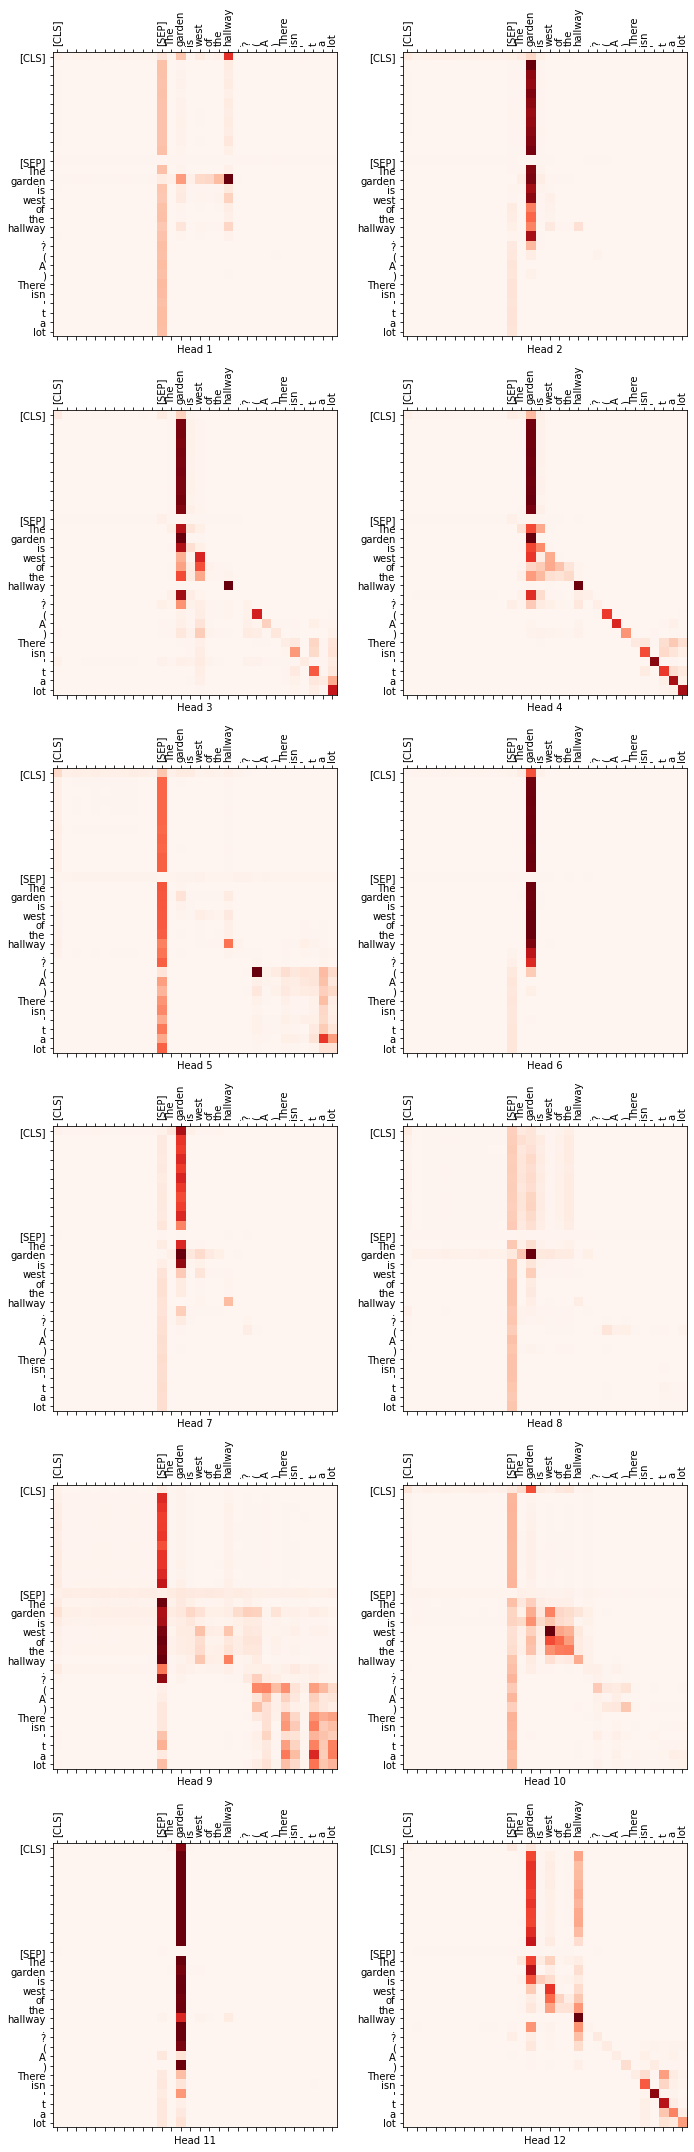

In [40]:
layer = -1
segment = 0
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg{segment}_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

### seg3

In [41]:
len(attentions), attentions[0].shape

(12, torch.Size([1, 12, 512, 512]))

In [42]:
head = 0
attentions[layer][bn][head]

tensor([[9.5618e-03, 2.4650e-03, 6.0229e-03,  ..., 3.5291e-02, 0.0000e+00,
         0.0000e+00],
        [1.0437e-03, 2.0909e-05, 5.4220e-05,  ..., 8.2446e-02, 0.0000e+00,
         0.0000e+00],
        [1.5069e-03, 3.6439e-05, 1.0060e-04,  ..., 8.1685e-02, 0.0000e+00,
         0.0000e+00],
        ...,
        [2.8820e-03, 1.7342e-03, 1.8779e-03,  ..., 3.9721e-03, 0.0000e+00,
         0.0000e+00],
        [2.4182e-03, 5.5880e-05, 9.0071e-05,  ..., 8.2442e-02, 0.0000e+00,
         0.0000e+00],
        [2.5509e-03, 1.0276e-04, 1.5790e-04,  ..., 8.1631e-02, 0.0000e+00,
         0.0000e+00]], grad_fn=<SelectBackward>)

<Figure size 720x720 with 0 Axes>

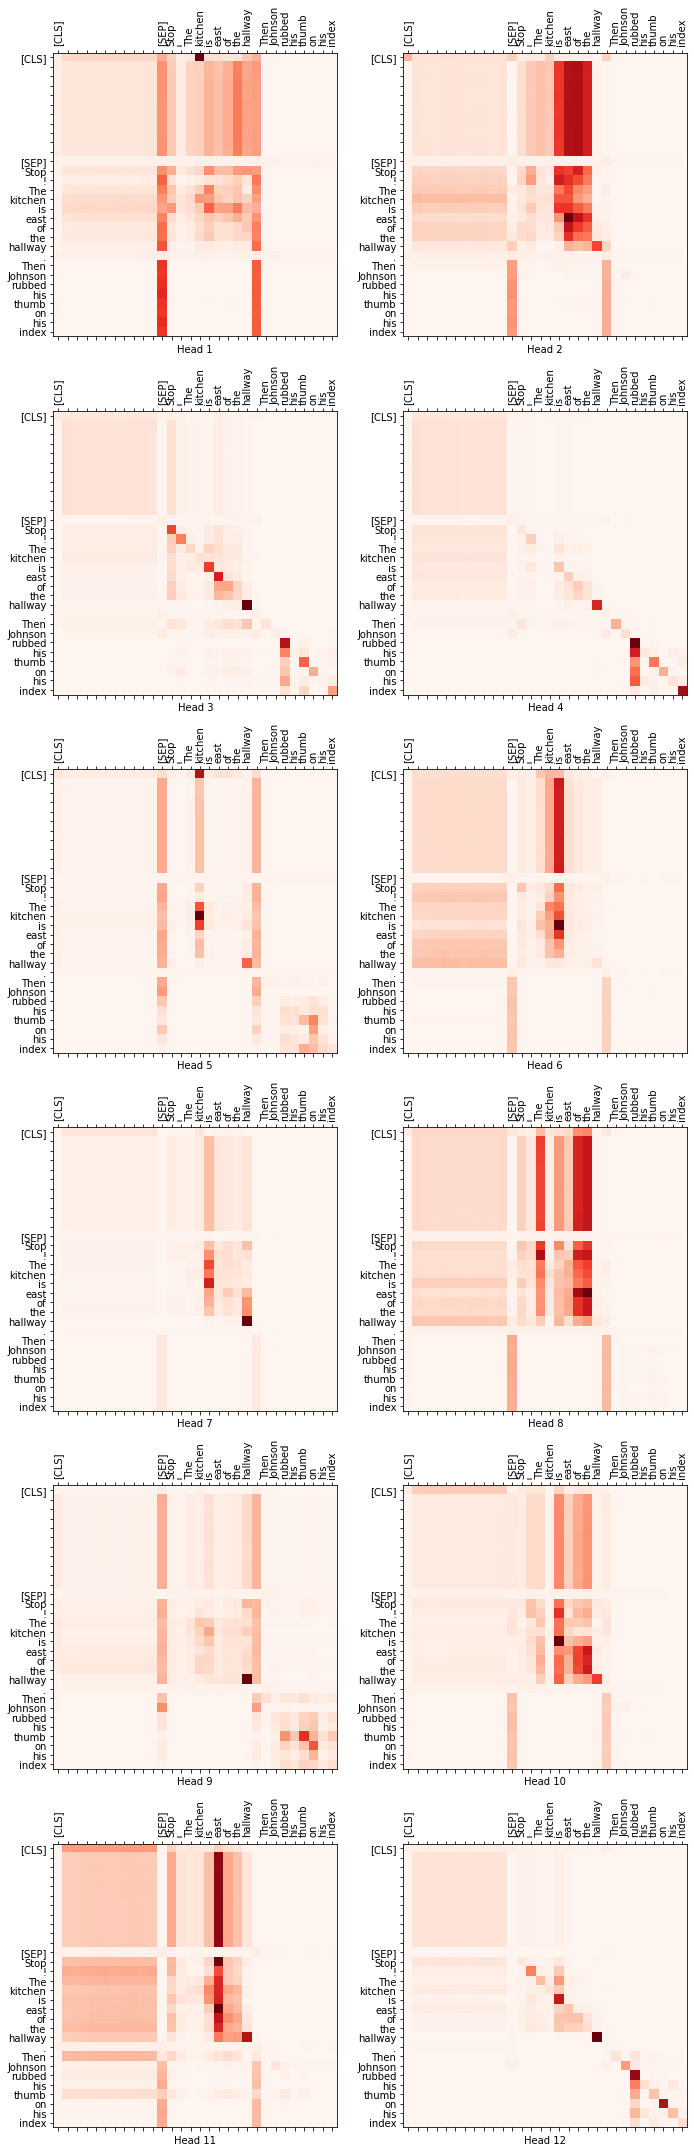

In [43]:
layer = -1
segment = 3
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg{segment}_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

### last seg

<Figure size 720x720 with 0 Axes>

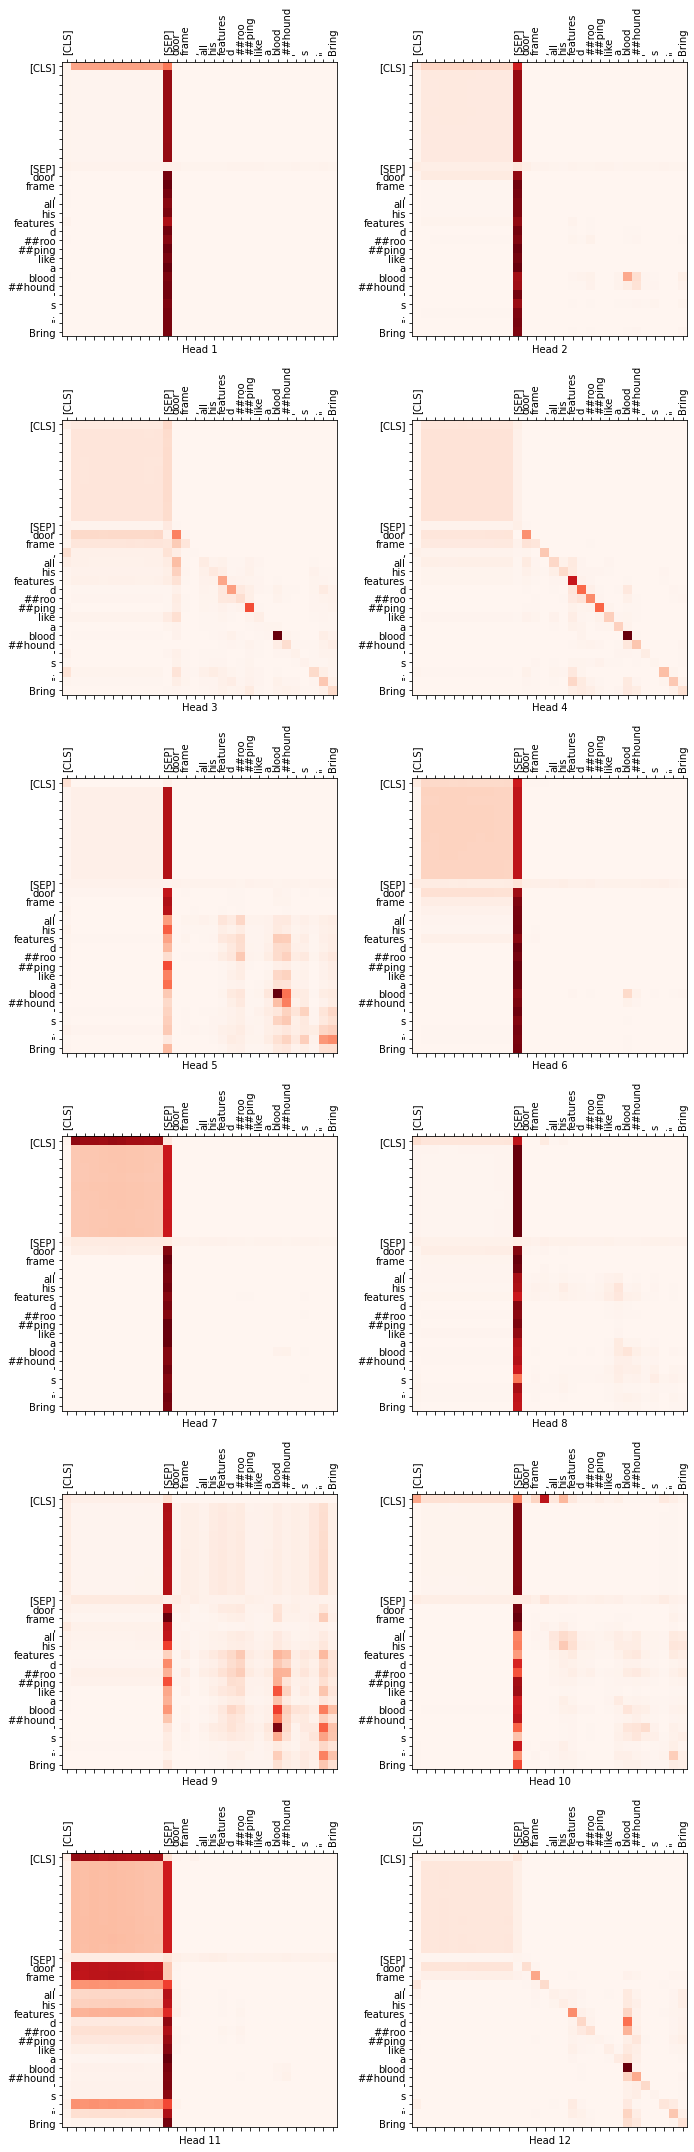

Traceback (most recent call last):
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
    app.start()
  File "/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 1823, in

: 

In [46]:
layer = -1
segment = 5
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg{segment}_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

### shortpaper

In [68]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def plot_attention_weights(attentions, tokens, y_tokens=None, p_attentions=None, filename='att.png', save=False, size=None, fontdict = {'fontsize': 10}):
    # attentions n_layers x n_heads x len x len
    
    attention = attentions.detach().clone()
    if size is not None:
        sz = size
    else:
        sz = max(*attention.shape) // 3
    fig = plt.figure(figsize=(3*sz, 3*sz))
    if y_tokens is None:
        y_tokens = tokens
        fig = plt.figure(figsize=(sz, 3*sz))
    y_tokens = y_tokens[:attention.shape[1]]
    tokens = tokens[:attention.shape[2]]    

    
    # if p_attentions:
    #     p_attention = p_attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(6, 2, head+1)

        # plot the attention weights
        if p_attentions:
            att = np.concatenate([np.expand_dims(p_attention[head], axis=0), attention[head]], axis=0)
            ax.matshow(att[:len(y_tokens)+1,:len(tokens)], cmap='Reds')
        else:
            ax.matshow(attention[head][:len(y_tokens),:len(tokens)], cmap='Reds')

        ax.set_xticks(range(len(tokens)))
        if p_attentions:
            ax.set_yticks(range(len(y_tokens) + 1))
            ax.set_yticklabels(['[P]'] + y_tokens, fontdict)
        else:
            ax.set_yticks(range(len(y_tokens)))
            # print('y_tokens', len(y_tokens), y_tokens)
            ax.set_yticklabels(y_tokens, **fontdict)

        ax.set_xticklabels(tokens, fontdict=fontdict, rotation=90)

        ax.set_xlabel('Head {}'.format(head+1), fontdict)

    plt.tight_layout()
    if save:
        plt.savefig(filename, format='pdf')
    plt.show()

<Figure size 6480x6480 with 0 Axes>

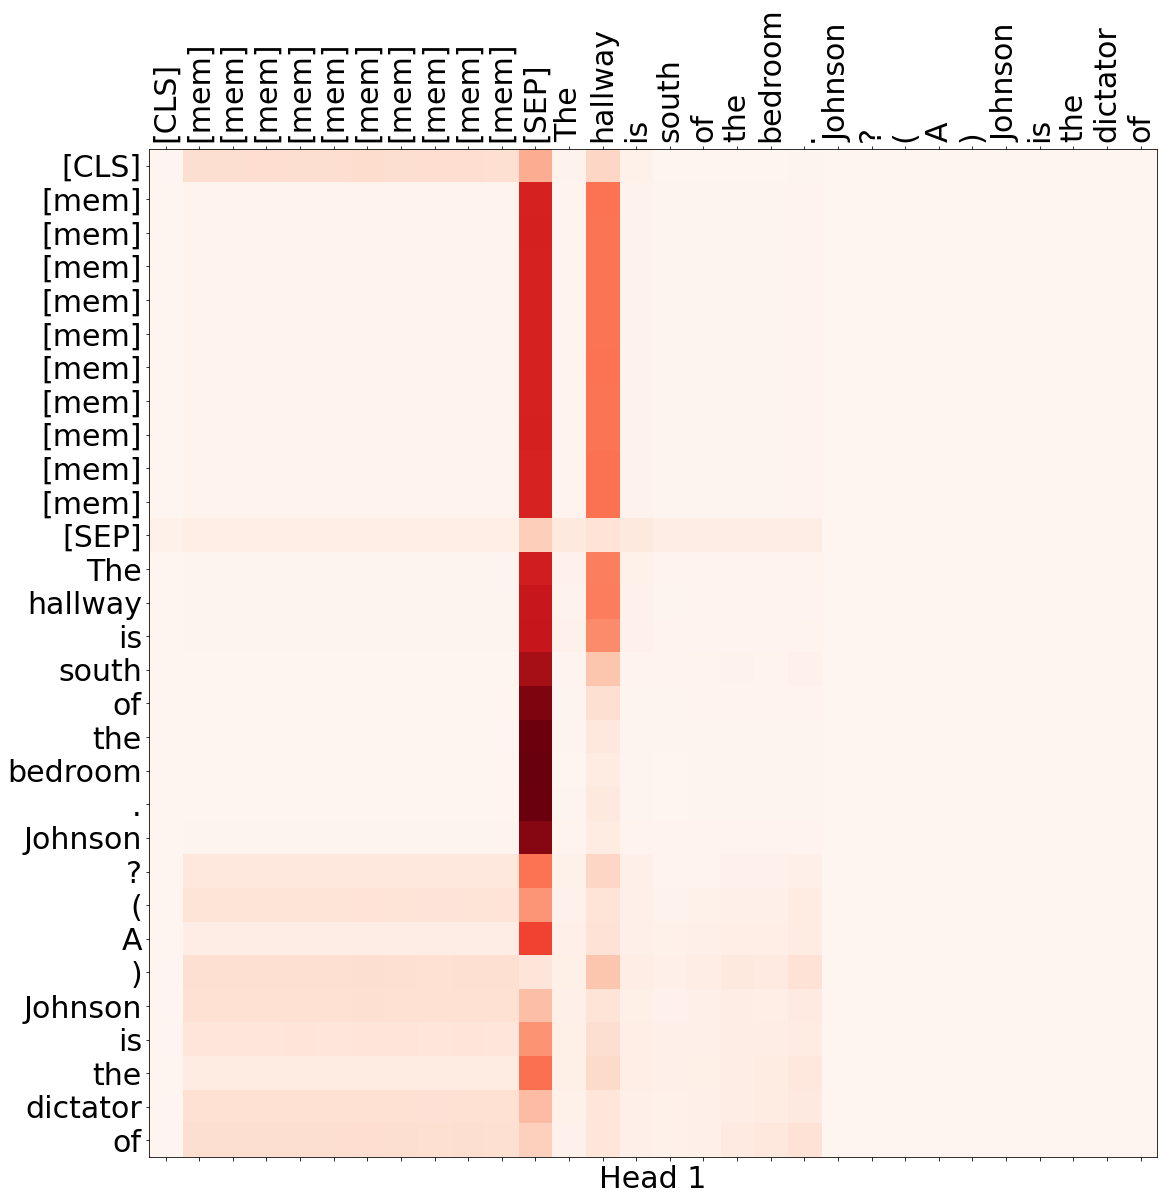

In [54]:
# write to mem
layer = -1
segment = 0
bn = 0
h = 2

min_x, max_x = 0, 30
min_y, max_y = 0, 30


size = 30
tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out[f'attentions_{segment}']
for i in range(1, 11):
    tokens[i] = '[mem]'

fn = f'img/rmt5_attn_seg{segment}_l{layer}.pdf'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x][h:h+1], tokens, y_tokens=None, p_attentions=None, filename=fn, save=True, size=size, fontdict={'size': size})

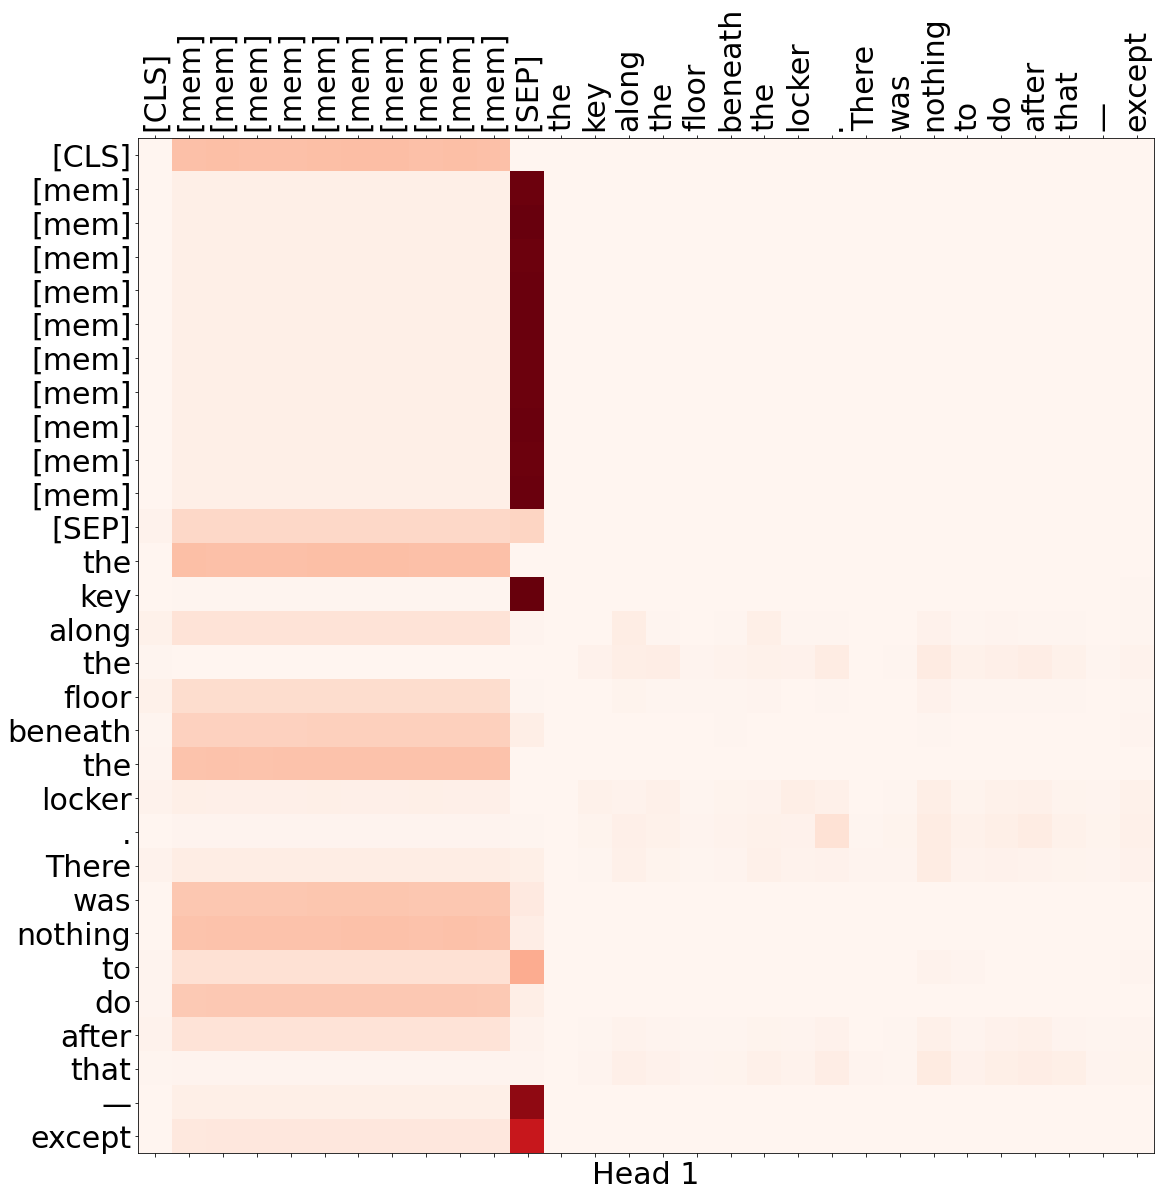

In [58]:
# retain in mem
layer = -1
segment = 1
bn = 0
h = 3

min_x, max_x = 0, 30
min_y, max_y = 0, 30


size = 30
tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]][min_x:max_x]
y_tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]][min_y:max_y]
attentions = out[f'attentions_{segment}']
for i in range(1, 11):
    tokens[i] = '[mem]'
    y_tokens[i] = '[mem]'

fn = f'img/rmt5_attn_seg{segment}_l{layer}.pdf'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x][h:h+1], tokens, y_tokens=y_tokens, p_attentions=None, filename=fn, save=False, size=size, fontdict={'size': size})

<Figure size 6480x6480 with 0 Axes>

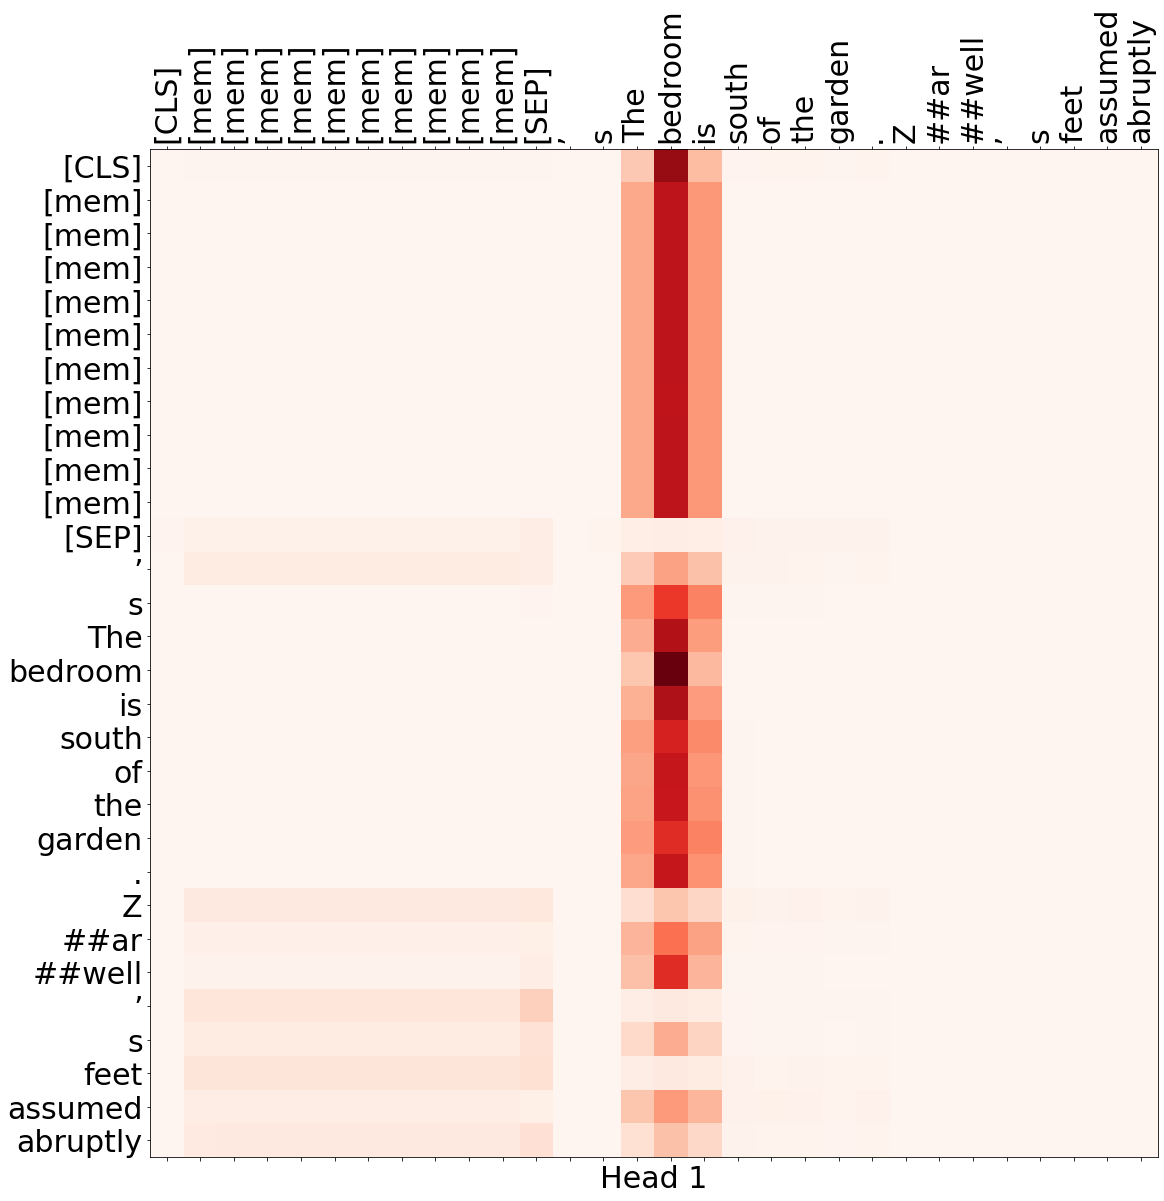

In [59]:
# reasoning in mem
layer = -1
segment = 2
bn = 0
h = 11

min_x, max_x = 0, 30
min_y, max_y = 0, 30


size = 30
tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out[f'attentions_{segment}']
for i in range(1, 11):
    tokens[i] = '[mem]'

fn = f'img/rmt5_attn_seg{segment}_l{layer}.pdf'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x][h:h+1], tokens, y_tokens=None, p_attentions=None, filename=fn, save=True, size=size, fontdict={'size': size})

In [76]:
attentions = out[f'attentions_{segment}']
attentions[layer][bn][h:h+1]

torch.Size([1, 512, 512])

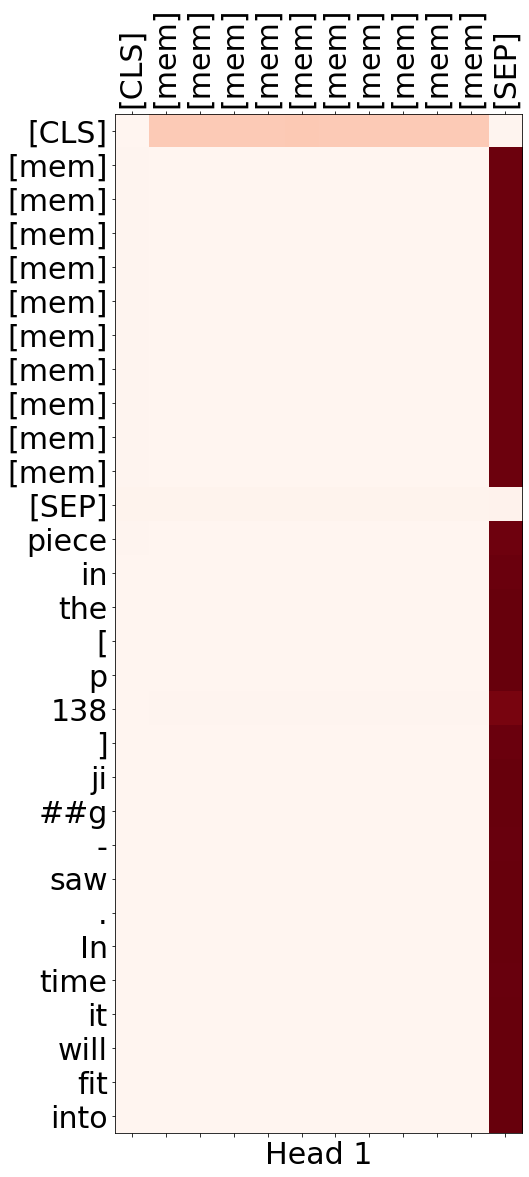

In [82]:
# read from mem
layer = -1
segment = 3
bn = 0
h = 0

min_x, max_x = 0, 12
min_y, max_y = 0, 30


size = 30
tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]][min_x:max_x]
y_tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]][min_y:max_y]
attentions = out[f'attentions_{segment}']
for i in range(1, 11):
    tokens[i] = '[mem]'
    y_tokens[i] = '[mem]'

fn = f'img/rmt5_attn_seg{segment}_l{layer}.pdf'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x][h:h+1], tokens, y_tokens=y_tokens, p_attentions=None, filename=fn, save=False, size=size, fontdict={'size': size})

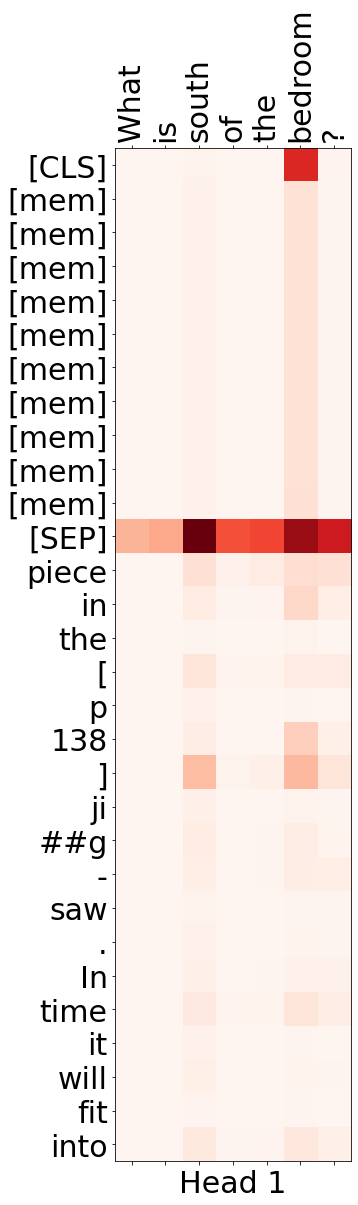

In [83]:
# read from mem
layer = -1
segment = 3
bn = 0
h = 0

min_x, max_x = -8, -1
min_y, max_y = 0, 30


size = 30
tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]][min_x:max_x]
y_tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]][min_y:max_y]
attentions = out[f'attentions_{segment}']
for i in range(1, 11):
#     tokens[i] = '[mem]'
    y_tokens[i] = '[mem]'

fn = f'img/rmt5_attn_seg{segment}_l{layer}.pdf'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x][h:h+1], tokens, y_tokens=y_tokens, p_attentions=None, filename=fn, save=False, size=size, fontdict={'size': size})